In [1]:
import os
import zarr
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


class CFG:
    particles_name = [
        "apo-ferritin",
        "beta-amylase",
        "beta-galactosidase",
        "ribosome",
        "thyroglobulin",
        "virus-like-particle",
    ]

    resolution2ratio = {
        "A": 1 / 10,
        "0": 1,
        "1": 2,
        "2": 4,
    }

    particles2cls = {
        "none": 0,
        "apo-ferritin": 1,
        "beta-amylase": 2,
        "beta-galactosidase": 3,
        "ribosome": 4,
        "thyroglobulin": 5,
        "virus-like-particle": 6,
    }
    cls2particles = {
        0: "none",
        1: "apo-ferritin",
        2: "beta-amylase",
        3: "beta-galactosidase",
        4: "ribosome",
        5: "thyroglobulin",
        6: "virus-like-particle",
    }

    particle_radius = {
        "apo-ferritin": 60,
        "beta-amylase": 65,
        "beta-galactosidase": 90,
        "ribosome": 150,
        "thyroglobulin": 130,
        "virus-like-particle": 135,
    }

    particle_weights = {
        "apo-ferritin": 1,
        "beta-amylase": 0,
        "beta-galactosidase": 2,
        "ribosome": 1,
        "thyroglobulin": 2,
        "virus-like-particle": 1,
    }

    colormap = {
        # -1の場合は透明の色
    }


def read_zarr(zarr_pth, resolution="0"):
    zarr_store = zarr.open(zarr_pth, mode="r")

    tomogram = zarr_store[resolution][:]

    return tomogram


def read_info_json(
    base_dir="../inputs/train/overlay/ExperimentRuns/",
    exp_name="TS_5_4",
    particle_name="apo-ferritin",
):

    keys = set(
        [
            "apo-ferritin",
            "beta-amylase",
            "beta-galactosidase",
            "ribosome",
            "thyroglobulin",
            "virus-like-particle",
        ]
    )

    if particle_name not in keys:
        raise ValueError(
            f"Particle name should be one of the following: {keys}. Got {particle_name}."
        )

    read_json_path = os.path.join(base_dir, exp_name, "Picks", f"{particle_name}.json")

    with open(read_json_path, "r") as f:
        particle_info = json.load(f)

    coords = []
    for point in particle_info["points"]:
        coords.append(
            [point["location"]["z"], point["location"]["y"], point["location"]["x"]]
        )

    coords = np.array(coords)

    return coords


def scale_coordinates(coords, tomogram_shape, resolution):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()

    # scaled_coords[:, 0] = coords[:, 0] / 10  # / coords[:, 0].max() * tomogram_shape[0]
    # scaled_coords[:, 1] = coords[:, 1] / 10  # / coords[:, 1].max() * tomogram_shape[1]
    # scaled_coords[:, 2] = coords[:, 2] / 10  # / coords[:, 2].max() * tomogram_shape[2]

    resolution_info = CFG.resolution2ratio
    scaled_coords[:, 0] = (
        coords[:, 0] * resolution_info["A"] / resolution_info[resolution]
    )
    scaled_coords[:, 1] = (
        coords[:, 1] * resolution_info["A"] / resolution_info[resolution]
    )
    scaled_coords[:, 2] = (
        coords[:, 2] * resolution_info["A"] / resolution_info[resolution]
    )

    return scaled_coords


def create_dataset(
    zarr_type="ctfdeconvolved",
    base_dir="../../inputs/train/",
    exp_name="TS_5_4",
    resolution="0",
    particle_names=[],
):
    zarr_name = f"{zarr_type}.zarr"
    zarr_pth = os.path.join(
        base_dir, "static/ExperimentRuns", exp_name, "VoxelSpacing10.000/", zarr_name
    )
    tomogram = read_zarr(zarr_pth, resolution=resolution)

    particle_info = {"corrds": {}, "scaled_corrds": {}}
    for particle_name in particle_names:
        coords = read_info_json(
            os.path.join(base_dir, "overlay/ExperimentRuns/"), exp_name, particle_name
        )
        scaled_coords = scale_coordinates(coords, tomogram.shape, resolution)
        particle_info["corrds"][particle_name] = coords
        particle_info["scaled_corrds"][particle_name] = scaled_coords

    return tomogram, particle_info


def normalise_by_percentile(data, min=5, max=99):
    min = np.percentile(data, min)
    max = np.percentile(data, max)
    data = (data - min) / (max - min)
    return data, min, max


class EziiDataset(Dataset):
    def __init__(
        self,
        exp_names=[],
        base_dir="../../inputs/train/static",
        particles_name=CFG.particles_name,
        resolution="0",
        zarr_type=["ctfdeconvolved"],
    ):
        self.exp_names = exp_names
        self.base_dir = base_dir
        self.particles_name = particles_name
        self.resolution = resolution
        self.zarr_type = zarr_type

        # exp_namesとzarr_typeの総当たりでデータを作成
        self.data = []
        for exp_name in exp_names:
            for type_ in zarr_type:
                self.data.append((exp_name, type_))

        print(self.data)

    def __getitem__(self, i):
        exp_name, type_ = self.data[i]  # TS_6_6

        tomogram, particle_info = create_dataset(
            particle_names=self.particles_name,
            resolution=self.resolution,
            exp_name=exp_name,
            zarr_type=type_,
        )

        normalized_tomogram, min, max = normalise_by_percentile(tomogram)
        apo_ferritin = particle_info["scaled_corrds"]["apo-ferritin"]
        beta_amylase = particle_info["scaled_corrds"]["beta-amylase"]
        beta_galactosidase = particle_info["scaled_corrds"]["beta-galactosidase"]
        ribosome = particle_info["scaled_corrds"]["ribosome"]
        thyroglobulin = particle_info["scaled_corrds"]["thyroglobulin"]
        virus_like_particle = particle_info["scaled_corrds"]["virus-like-particle"]

        prticle_corrds = {
            "apo-ferritin": apo_ferritin,
            "beta-amylase": beta_amylase,
            "beta-galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus-like-particle": virus_like_particle,
        }

        segmentation_map = create_segmentation_map(
            tomogram, resolution=self.resolution, particle_coords=prticle_corrds
        )

        tomogram = padding(tomogram, self.resolution)
        normalized_tomogram = padding(normalized_tomogram, self.resolution)
        segmentation_map = padding(segmentation_map, self.resolution)

        return {
            "resolution": self.resolution,
            "exp_name": exp_name,
            "tomogram": tomogram,
            "normalized_tomogram": normalized_tomogram,
            "segmentation_map": segmentation_map,
            "apo_ferritin": apo_ferritin,
            "beta_amylase": beta_amylase,
            "beta_galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus_like_particle": virus_like_particle,
            "particle_corrds": prticle_corrds,
        }

    def __len__(self):
        return len(self.data)


def padding(tomogram, resolution):
    if resolution == "0":  # 184, 630, 630 -> 184, 640, 640
        tomogram = np.pad(tomogram, ((0, 0), (5, 5), (5, 5)), mode="constant")
        return tomogram
    elif resolution == "1":  # 92, 315, 315 -> 92, 320, 320
        tomogram = np.pad(tomogram, ((0, 0), (2, 2), (2, 2)), mode="constant")
        return tomogram
    elif resolution == "2":  # 46, 158, 158 -> 46, 160, 160
        tomogram = np.pad(tomogram, ((0, 0), (1, 1), (1, 1)), mode="constant")
        return tomogram
    raise ValueError(
        f"Resolution should be one of the following: 0, 1, 2. Got {resolution}."
    )


def create_segmentation_map(tomogram, resolution, particle_coords={}):
    segmentation_map = np.zeros_like(tomogram)
    segmentation_map[:, :, :] = 0

    particle_radius = (
        CFG.particle_radius
    )  # {apo-ferritin: 60, beta-amylase: 65, beta-galactosidase: 90, ribosome: 150, thyroglobulin: 130, virus-like-particle: 135}
    particle2cls = CFG.particles2cls
    resolution_info = CFG.resolution2ratio  # {A: 1/10, 0: 1, 1: 2, 2: 4}

    r_by_particle = {}
    for particle_name, r in particle_radius.items():
        r_by_particle[particle_name] = (
            r * resolution_info["A"] / resolution_info[resolution]
        )

    for i, (paraticle_name, coords) in enumerate(particle_coords.items()):
        # print(coords.shape)
        for z, y, x in coords:
            z, y, x = int(z), int(y), int(x)
            cls = particle2cls[paraticle_name]
            r = r_by_particle[paraticle_name]
            z_min = int(max(0, z - r))
            z_max = int(min(tomogram.shape[0], z + r))
            y_min = int(max(0, y - r))
            y_max = int(min(tomogram.shape[1], y + r))
            x_min = int(max(0, x - r))
            x_max = int(min(tomogram.shape[2], x + r))

            # x,y,zを中心に円計上にクラスを埋める
            # segmentation_map[z_min:z_max, y_min:y_max, x_min:x_max] = cls
            for z_ in range(z_min, z_max):
                for y_ in range(y_min, y_max):
                    for x_ in range(x_min, x_max):
                        if (z - z_) ** 2 + (y - y_) ** 2 + (x - x_) ** 2 < r**2:
                            segmentation_map[z_, y_, x_] = cls

    return segmentation_map

[('TS_5_4', 'ctfdeconvolved')]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


903077

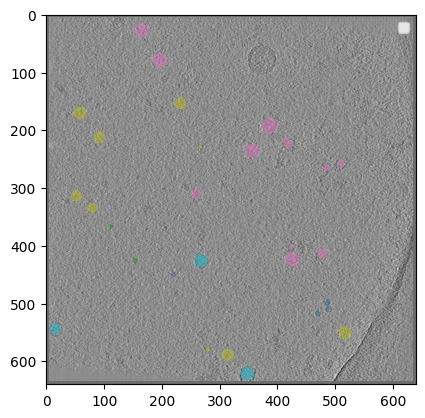

In [2]:
dataset = EziiDataset(
    exp_names=["TS_5_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 100
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)
plt.legend()

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

[('TS_6_4', 'ctfdeconvolved')]


182877

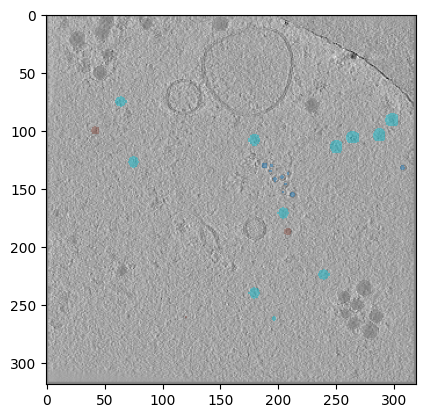

In [3]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="1",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 25
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

In [4]:
import torch
import torch.nn as nn
from icecream import ic
import segmentation_models_pytorch as smp


class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = smp.Unet(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=len(CFG.particles2cls),
        )

    def forward(self, x):

        x = self.model(x)

        return x

In [5]:
train_dataset = EziiDataset(
    exp_names=["TS_5_4", "TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
    # zarr_type=["ctfdeconvolved"],
    zarr_type=["denoised", "ctfdeconvolved", "wbp", "isonetcorrected"],
)

valid_dataset = EziiDataset(
    exp_names=["TS_86_3", "TS_6_6"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
    # zarr_type=["ctfdeconvolved"],
    zarr_type=["denoised"],
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_5_4', 'ctfdeconvolved'), ('TS_5_4', 'wbp'), ('TS_5_4', 'isonetcorrected'), ('TS_73_6', 'denoised'), ('TS_73_6', 'ctfdeconvolved'), ('TS_73_6', 'wbp'), ('TS_73_6', 'isonetcorrected'), ('TS_99_9', 'denoised'), ('TS_99_9', 'ctfdeconvolved'), ('TS_99_9', 'wbp'), ('TS_99_9', 'isonetcorrected'), ('TS_6_4', 'denoised'), ('TS_6_4', 'ctfdeconvolved'), ('TS_6_4', 'wbp'), ('TS_6_4', 'isonetcorrected'), ('TS_69_2', 'denoised'), ('TS_69_2', 'ctfdeconvolved'), ('TS_69_2', 'wbp'), ('TS_69_2', 'isonetcorrected')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/20 [00:00<?, ?it/s]


46

Valid-Epoch: 0, Loss: 0.5842338641700537: 100%|██████████| 92/92 [00:03<00:00, 30.49it/s] 


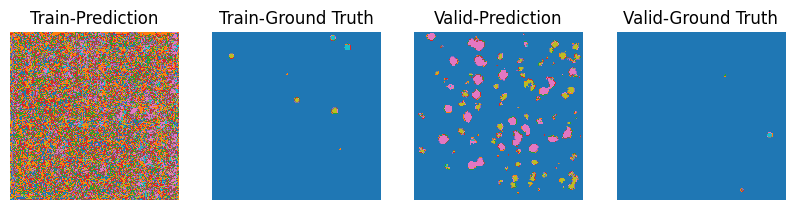

Epoch: 0, Loss: 0.17440727353096008


Valid-Epoch: 1, Loss: 0.9807941918463811: 100%|██████████| 92/92 [00:02<00:00, 30.90it/s]


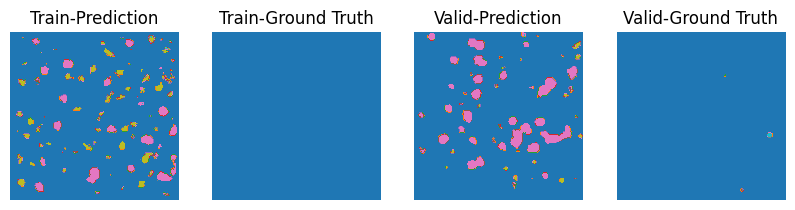

Epoch: 1, Loss: 0.05516912415623665


Valid-Epoch: 2, Loss: 0.9934579433225419: 100%|██████████| 92/92 [00:03<00:00, 30.05it/s]


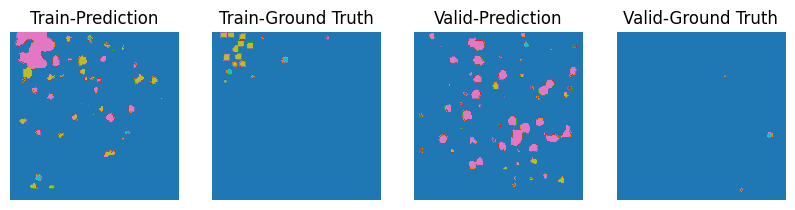

Epoch: 2, Loss: 0.0440472736954689


Valid-Epoch: 3, Loss: 0.9146384034386795: 100%|██████████| 92/92 [00:02<00:00, 31.18it/s]


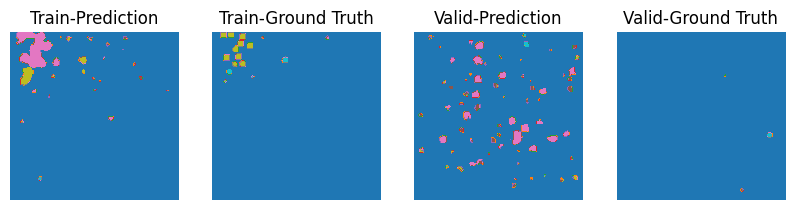

Epoch: 3, Loss: 0.0508410818874836


Valid-Epoch: 4, Loss: 1.4561656686558349: 100%|██████████| 92/92 [00:03<00:00, 29.60it/s] 


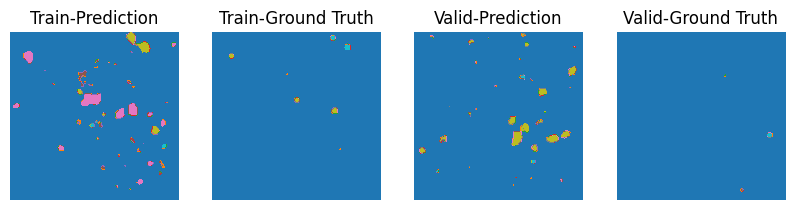

Epoch: 4, Loss: 0.020235838368535042


Valid-Epoch: 5, Loss: 1.3941442962108261: 100%|██████████| 92/92 [00:03<00:00, 29.75it/s]


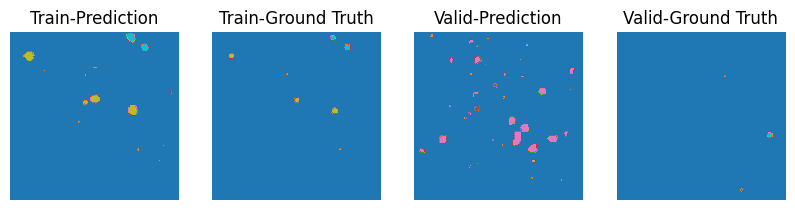

Epoch: 5, Loss: 0.012351521290838718


Valid-Epoch: 6, Loss: 1.6186122022032656: 100%|██████████| 92/92 [00:03<00:00, 30.63it/s]


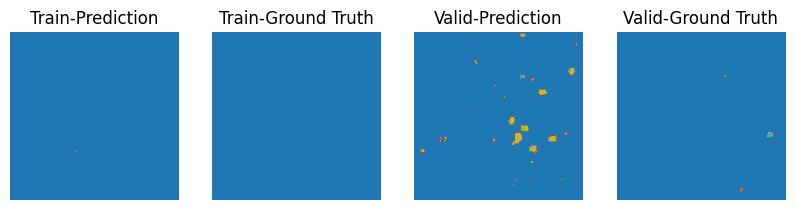

Epoch: 6, Loss: 0.01613290049135685


Valid-Epoch: 7, Loss: 1.840638541259661: 100%|██████████| 92/92 [00:03<00:00, 27.98it/s] 


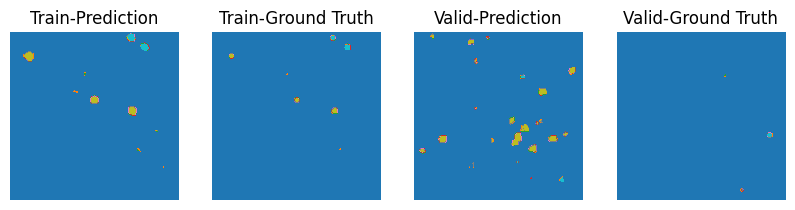

Epoch: 7, Loss: 0.01327924057841301


Valid-Epoch: 8, Loss: 1.9042281848410114: 100%|██████████| 92/92 [00:02<00:00, 30.78it/s]


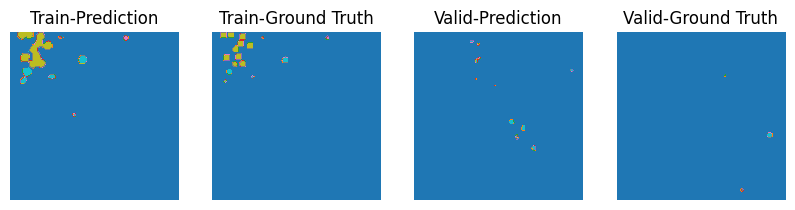

Epoch: 8, Loss: 0.0005560926510952413


Valid-Epoch: 9, Loss: 1.4393564207509726: 100%|██████████| 92/92 [00:02<00:00, 31.11it/s]


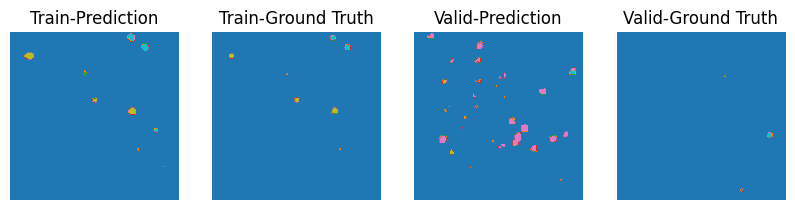

Epoch: 9, Loss: 0.003951270133256912


Valid-Epoch: 10, Loss: 2.2101609095846904: 100%|██████████| 92/92 [00:03<00:00, 30.19it/s]


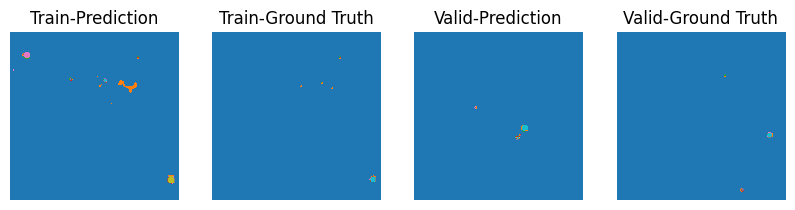

Epoch: 10, Loss: 0.001032324624247849


Valid-Epoch: 11, Loss: 3.2165723791847047: 100%|██████████| 92/92 [00:02<00:00, 31.27it/s]


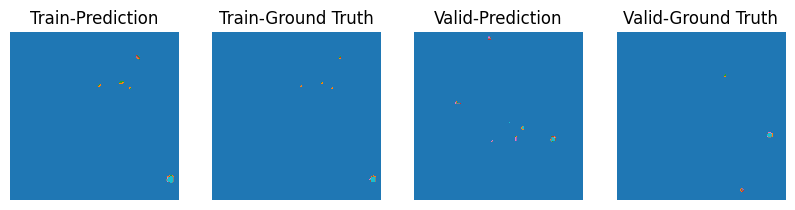

Epoch: 11, Loss: 0.00021920932340435684


Valid-Epoch: 12, Loss: 2.3200365350223917: 100%|██████████| 92/92 [00:02<00:00, 30.83it/s]


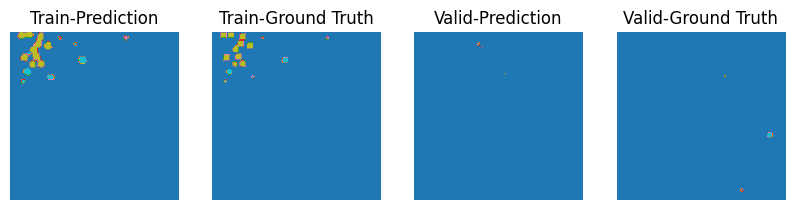

Epoch: 12, Loss: 0.00014919282693881541


Valid-Epoch: 13, Loss: 2.173327201353696: 100%|██████████| 92/92 [00:03<00:00, 30.09it/s] 


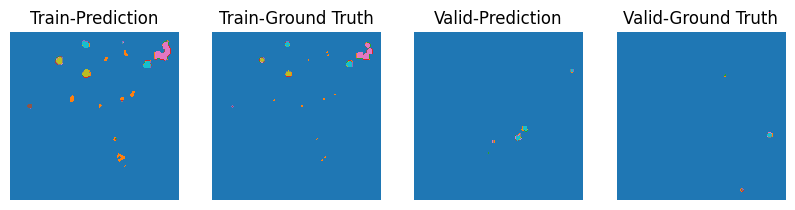

Epoch: 13, Loss: 0.0029174608644098043


Valid-Epoch: 14, Loss: 2.3854873044673024: 100%|██████████| 92/92 [00:02<00:00, 31.14it/s]


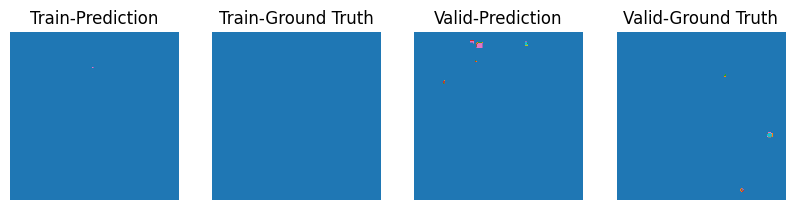

Epoch: 14, Loss: 0.00031526750535704195


Valid-Epoch: 15, Loss: 2.68763344687823: 100%|██████████| 92/92 [00:03<00:00, 28.34it/s]  


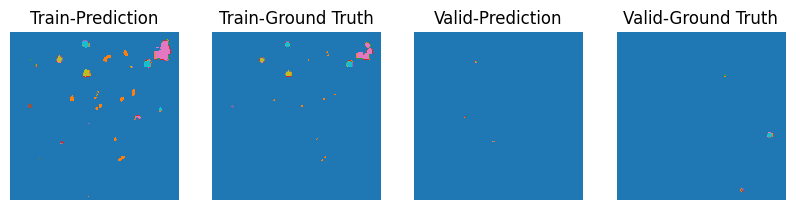

Epoch: 15, Loss: 6.478056457126513e-05


Valid-Epoch: 16, Loss: 2.2681226446198393: 100%|██████████| 92/92 [00:03<00:00, 30.04it/s]


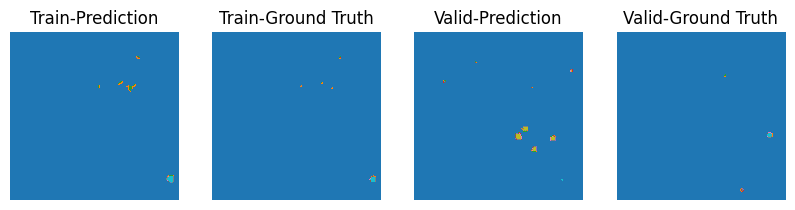

Epoch: 16, Loss: 0.001417804043740034


Valid-Epoch: 17, Loss: 2.297006342594871: 100%|██████████| 92/92 [00:02<00:00, 30.72it/s] 


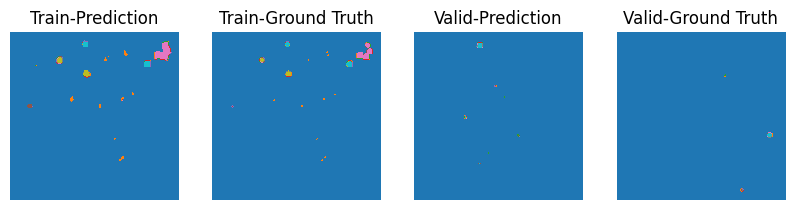

Epoch: 17, Loss: 2.470487197570037e-05


Valid-Epoch: 18, Loss: 2.011156009211529: 100%|██████████| 92/92 [00:03<00:00, 30.60it/s] 


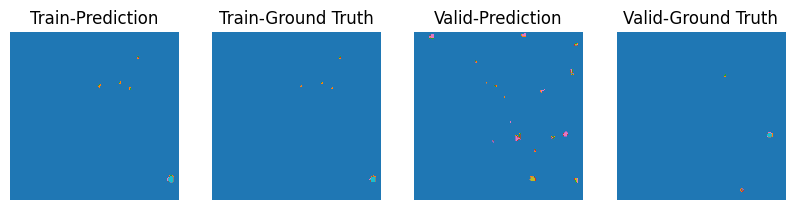

Epoch: 18, Loss: 0.007466339506208897


Valid-Epoch: 19, Loss: 2.5209176721642783: 100%|██████████| 92/92 [00:03<00:00, 28.94it/s]


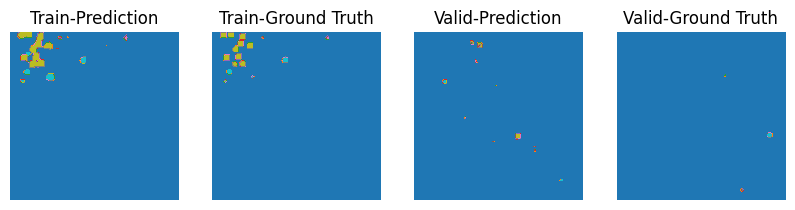

Epoch: 19, Loss: 0.00012111484102206305


Valid-Epoch: 20, Loss: 2.1923442696816378: 100%|██████████| 92/92 [00:02<00:00, 30.81it/s]


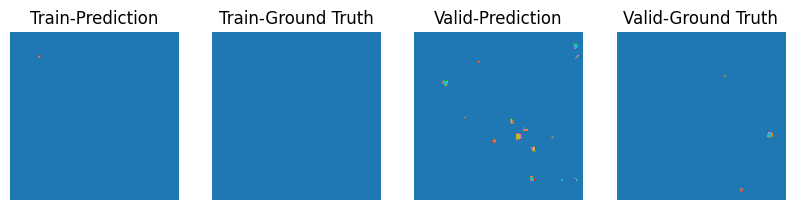

Epoch: 20, Loss: 0.00275530107319355


Valid-Epoch: 21, Loss: 3.019507484399899: 100%|██████████| 92/92 [00:03<00:00, 28.07it/s] 


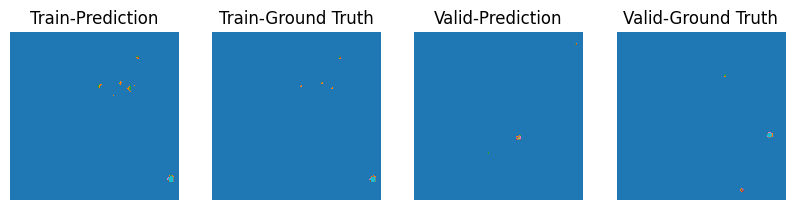

Epoch: 21, Loss: 0.0003390982747077942


Valid-Epoch: 22, Loss: 4.2672574777239864: 100%|██████████| 92/92 [00:03<00:00, 27.90it/s]


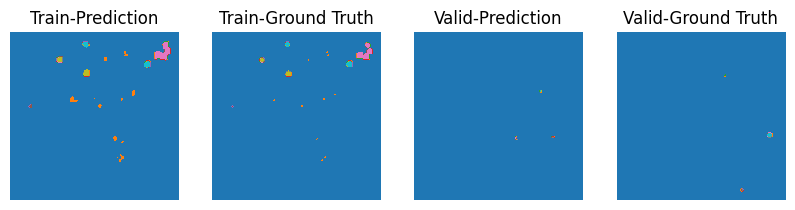

Epoch: 22, Loss: 4.797775181941688e-05


Valid-Epoch: 23, Loss: 2.292551015802335: 100%|██████████| 92/92 [00:03<00:00, 30.35it/s] 


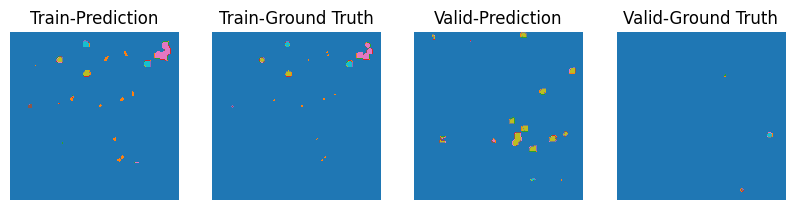

Epoch: 23, Loss: 0.0011289330432191491


Valid-Epoch: 24, Loss: 2.688164226541986: 100%|██████████| 92/92 [00:03<00:00, 29.27it/s] 


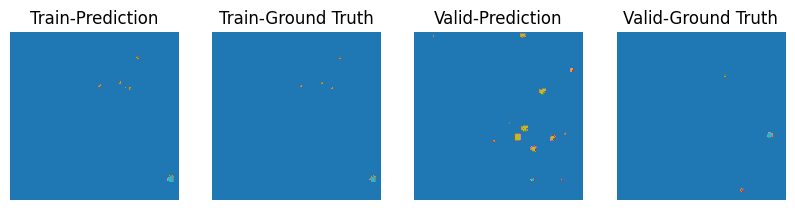

Epoch: 24, Loss: 0.00015500142762903124


Valid-Epoch: 25, Loss: 2.4474804045945824: 100%|██████████| 92/92 [00:03<00:00, 29.26it/s]


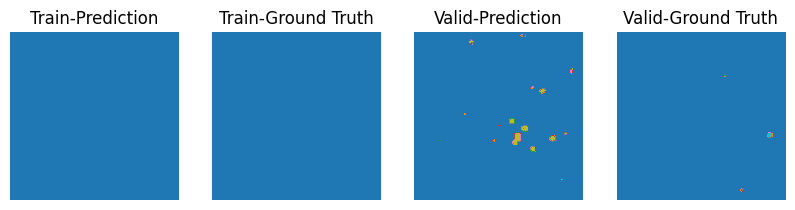

Epoch: 25, Loss: 0.0006624935776926577


Valid-Epoch: 26, Loss: 2.961101302888991: 100%|██████████| 92/92 [00:02<00:00, 31.15it/s] 


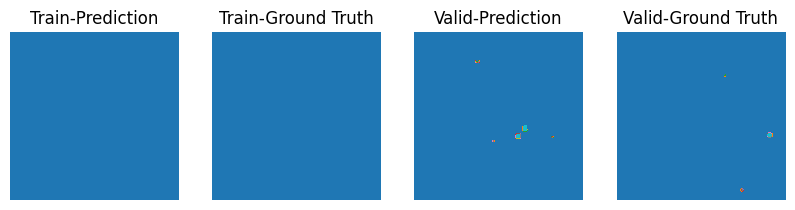

Epoch: 26, Loss: 2.5944817025447264e-05


Valid-Epoch: 27, Loss: 3.047175440495138: 100%|██████████| 92/92 [00:03<00:00, 29.07it/s] 


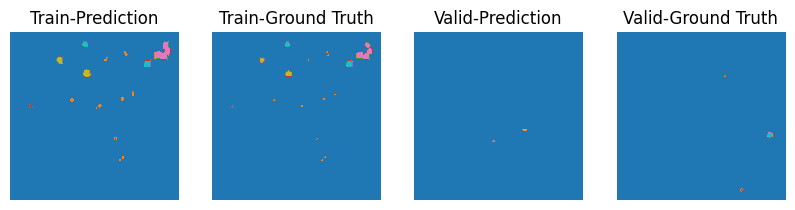

Epoch: 27, Loss: 2.0281941033317707e-05


Valid-Epoch: 28, Loss: 2.959611120445555: 100%|██████████| 92/92 [00:03<00:00, 30.43it/s] 


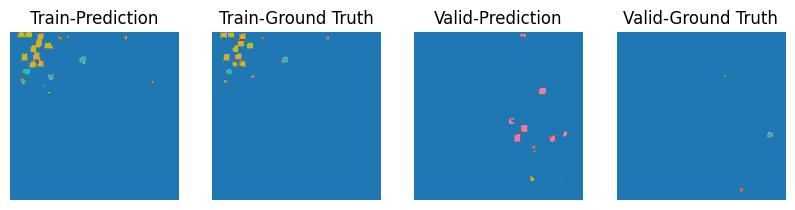

Epoch: 28, Loss: 0.0006530307000502944


Valid-Epoch: 29, Loss: 2.9135551486713114: 100%|██████████| 92/92 [00:03<00:00, 30.48it/s]


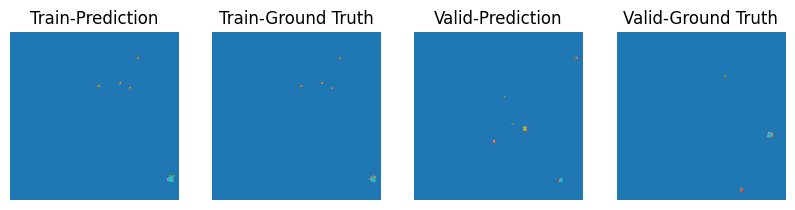

Epoch: 29, Loss: 0.001025057164952159


Valid-Epoch: 30, Loss: 3.4740208323987396: 100%|██████████| 92/92 [00:03<00:00, 30.59it/s]


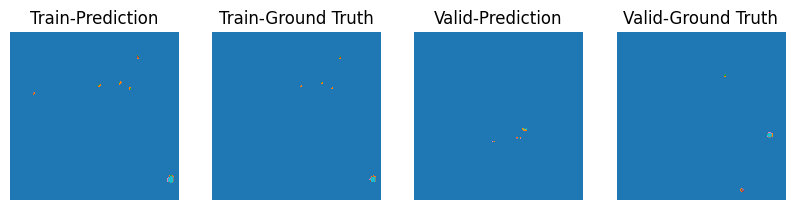

Epoch: 30, Loss: 2.0434861653484404e-05


Valid-Epoch: 31, Loss: 2.7448664471455193: 100%|██████████| 92/92 [00:03<00:00, 29.97it/s]


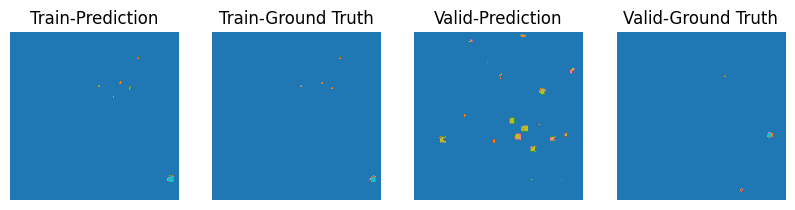

Epoch: 31, Loss: 0.0022727763280272484


Valid-Epoch: 32, Loss: 2.7615778662060144: 100%|██████████| 92/92 [00:02<00:00, 30.93it/s]


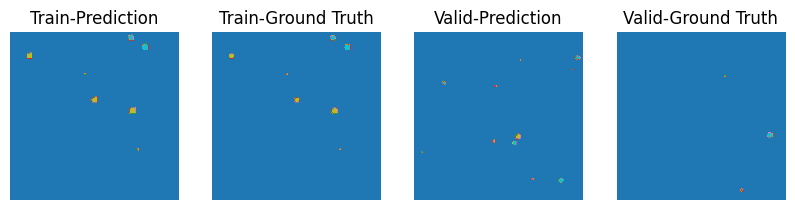

Epoch: 32, Loss: 0.0004097398486919701


Valid-Epoch: 33, Loss: 3.2840248033734913: 100%|██████████| 92/92 [00:03<00:00, 29.46it/s] 


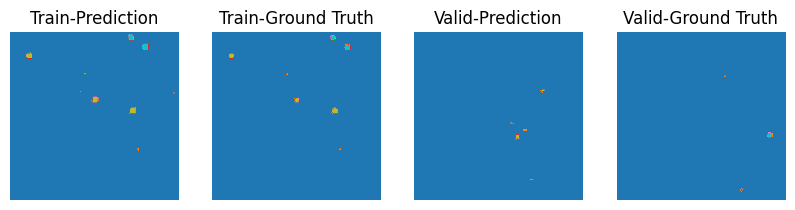

Epoch: 33, Loss: 1.060067461366998e-05


Valid-Epoch: 34, Loss: 3.870906089962798: 100%|██████████| 92/92 [00:02<00:00, 31.94it/s] 


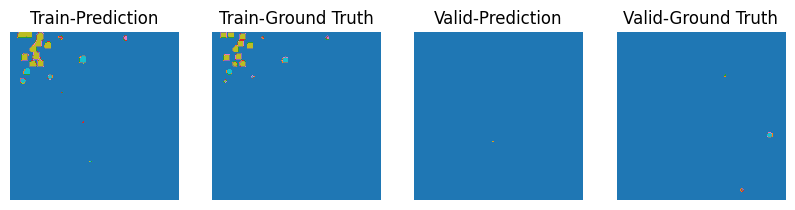

Epoch: 34, Loss: 3.9641499824938364e-06


Valid-Epoch: 35, Loss: 3.148813347670425: 100%|██████████| 92/92 [00:03<00:00, 28.54it/s] 


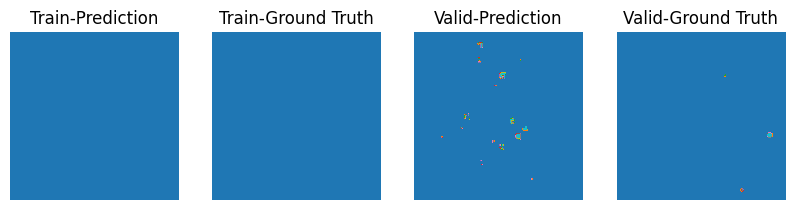

Epoch: 35, Loss: 3.669494390123873e-06


Valid-Epoch: 36, Loss: 2.9968853835370797: 100%|██████████| 92/92 [00:02<00:00, 30.88it/s]


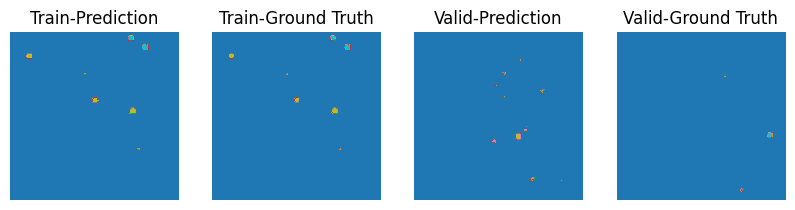

Epoch: 36, Loss: 0.0005133630475029349


Valid-Epoch: 37, Loss: 2.9853840860997756: 100%|██████████| 92/92 [00:03<00:00, 30.51it/s]


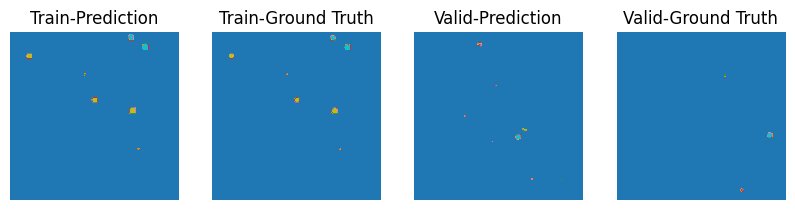

Epoch: 37, Loss: 0.0003296209033578634


Valid-Epoch: 38, Loss: 3.607685377249412: 100%|██████████| 92/92 [00:02<00:00, 30.84it/s] 


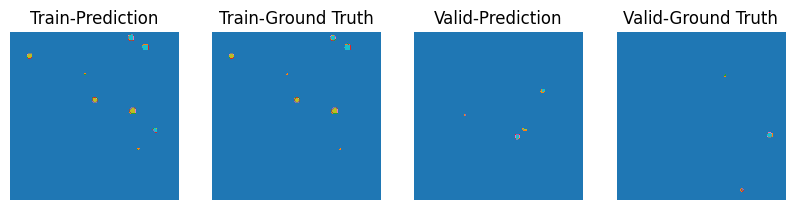

Epoch: 38, Loss: 0.0003618737973738462


Valid-Epoch: 39, Loss: 3.7872045766647044: 100%|██████████| 92/92 [00:03<00:00, 28.10it/s]


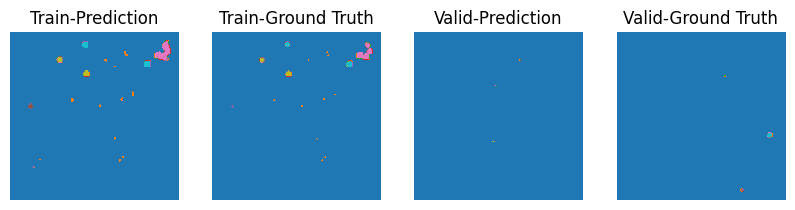

Epoch: 39, Loss: 1.2767070074914955e-05


Valid-Epoch: 40, Loss: 4.317066580378552: 100%|██████████| 92/92 [00:03<00:00, 30.61it/s] 


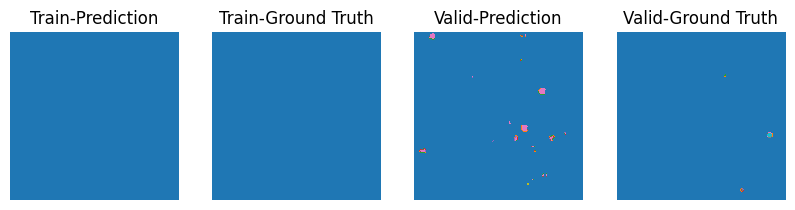

Epoch: 40, Loss: 0.0026970934122800827


Valid-Epoch: 41, Loss: 3.6084842049936903: 100%|██████████| 92/92 [00:03<00:00, 28.51it/s]


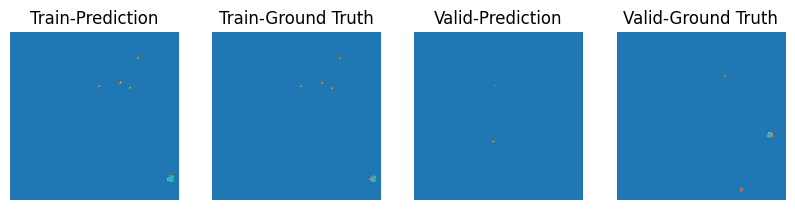

Epoch: 41, Loss: 6.804984423069982e-06


Valid-Epoch: 42, Loss: 3.1190233741563556: 100%|██████████| 92/92 [00:02<00:00, 30.76it/s]


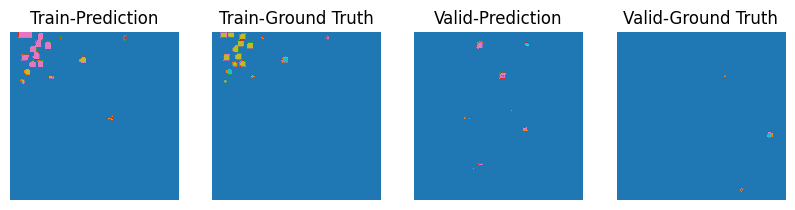

Epoch: 42, Loss: 2.8542701784317615e-06


Valid-Epoch: 43, Loss: 4.308471805316485: 100%|██████████| 92/92 [00:02<00:00, 31.54it/s] 


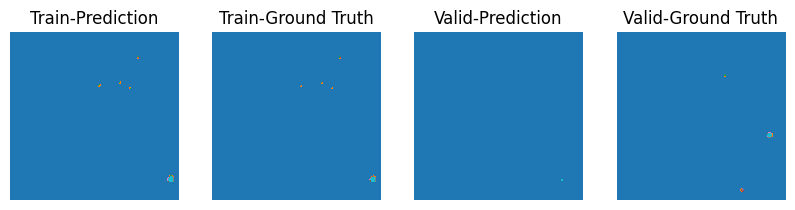

Epoch: 43, Loss: 2.8838153411925305e-06


Valid-Epoch: 44, Loss: 4.7425883285047705: 100%|██████████| 92/92 [00:03<00:00, 29.75it/s]


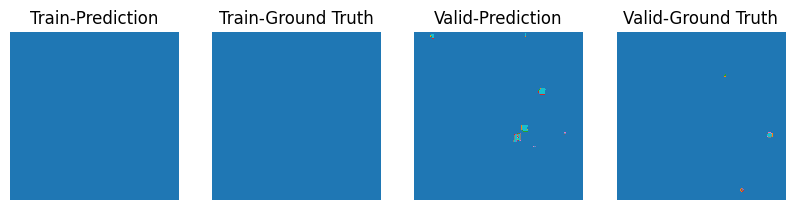

Epoch: 44, Loss: 0.0003734986239578575


Valid-Epoch: 45, Loss: 3.445894641942102: 100%|██████████| 92/92 [00:03<00:00, 28.56it/s] 


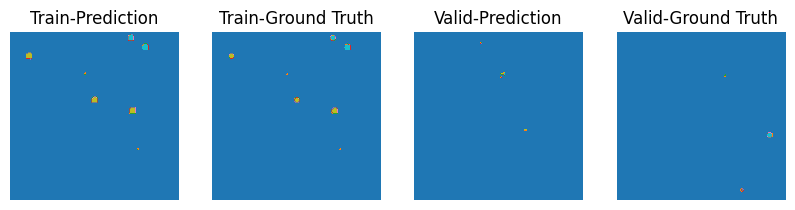

Epoch: 45, Loss: 2.1262180780468043e-06


Valid-Epoch: 46, Loss: 4.254775286685315: 100%|██████████| 92/92 [00:02<00:00, 31.21it/s] 


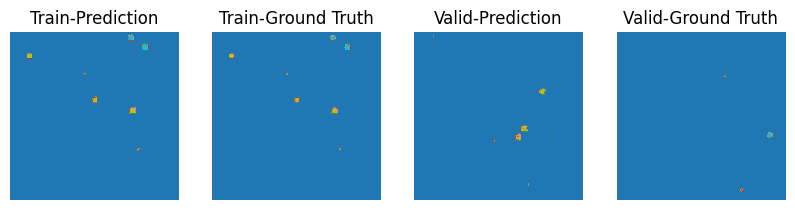

Epoch: 46, Loss: 7.530344737460837e-05


Valid-Epoch: 47, Loss: 3.4307632277382454: 100%|██████████| 92/92 [00:03<00:00, 28.62it/s]


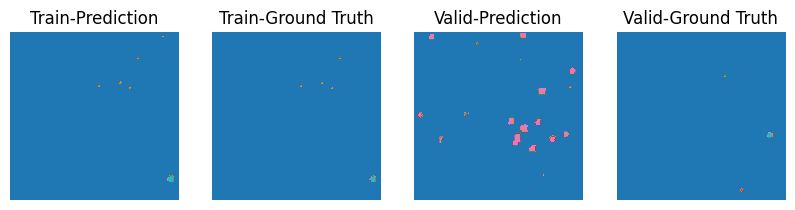

Epoch: 47, Loss: 0.0005599642754532397


Valid-Epoch: 48, Loss: 3.5859981416487363: 100%|██████████| 92/92 [00:03<00:00, 29.97it/s]


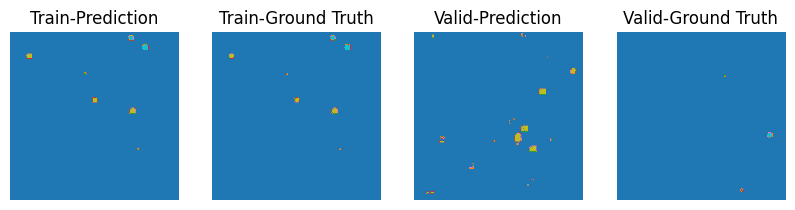

Epoch: 48, Loss: 0.0004968298599123955


Valid-Epoch: 49, Loss: 2.9649459864503234: 100%|██████████| 92/92 [00:03<00:00, 29.26it/s]  


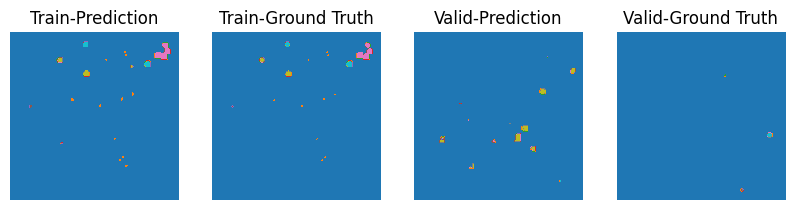

Epoch: 49, Loss: 0.0007631744374521077


Valid-Epoch: 50, Loss: 3.4946626304057564: 100%|██████████| 92/92 [00:03<00:00, 29.76it/s]


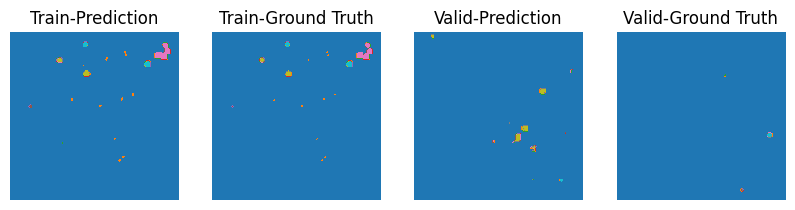

Epoch: 50, Loss: 0.001897476613521576


Valid-Epoch: 51, Loss: 3.359787022355832: 100%|██████████| 92/92 [00:02<00:00, 31.17it/s] 


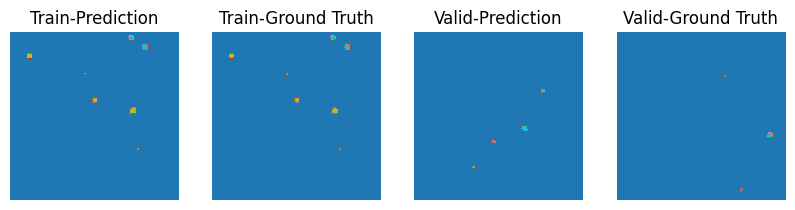

Epoch: 51, Loss: 0.00013700708223041147


Valid-Epoch: 52, Loss: 3.8445661386685575: 100%|██████████| 92/92 [00:03<00:00, 30.38it/s]


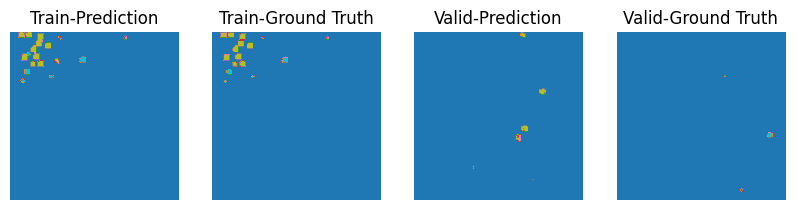

Epoch: 52, Loss: 0.00011373450251994655


Valid-Epoch: 53, Loss: 4.018733762889851: 100%|██████████| 92/92 [00:03<00:00, 29.86it/s] 


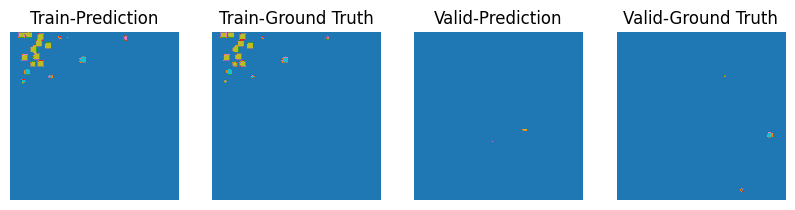

Epoch: 53, Loss: 1.5222557294691796e-06


Valid-Epoch: 54, Loss: 3.4932007165862617: 100%|██████████| 92/92 [00:03<00:00, 30.09it/s]


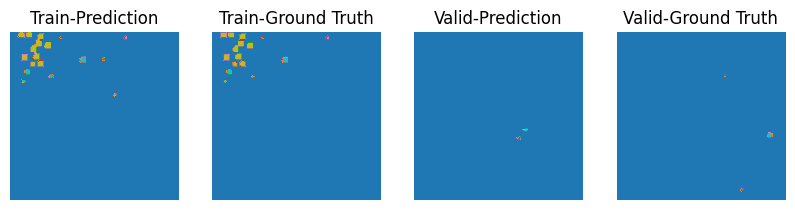

Epoch: 54, Loss: 1.284183554162155e-06


Valid-Epoch: 55, Loss: 3.944421666136718: 100%|██████████| 92/92 [00:02<00:00, 31.77it/s] 


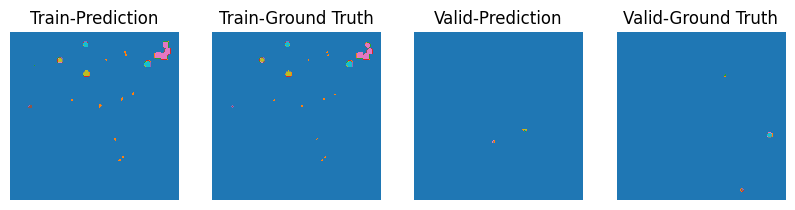

Epoch: 55, Loss: 6.623251920245821e-07


Valid-Epoch: 56, Loss: 3.9924339276116916: 100%|██████████| 92/92 [00:03<00:00, 29.94it/s]


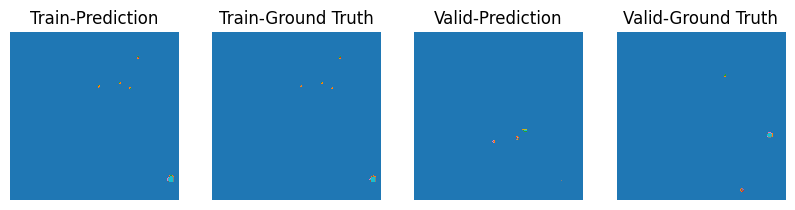

Epoch: 56, Loss: 9.068197073247575e-07


Valid-Epoch: 57, Loss: 3.370269870503029: 100%|██████████| 92/92 [00:03<00:00, 30.36it/s] 


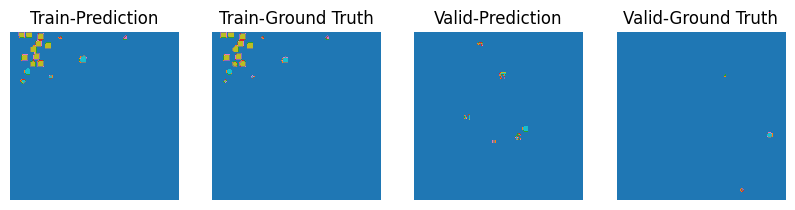

Epoch: 57, Loss: 1.042919961946609e-06


Valid-Epoch: 58, Loss: 3.3528790150147: 100%|██████████| 92/92 [00:02<00:00, 30.76it/s]   


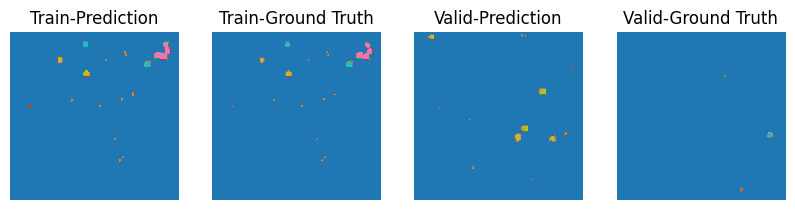

Epoch: 58, Loss: 0.0007508824928663671


Valid-Epoch: 59, Loss: 3.468555353953676: 100%|██████████| 92/92 [00:03<00:00, 29.98it/s] 


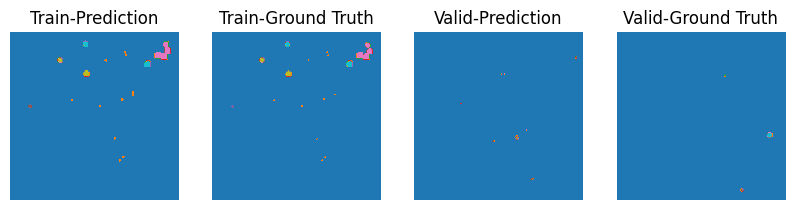

Epoch: 59, Loss: 1.9067447283305228e-06


Valid-Epoch: 60, Loss: 3.2565822599997527: 100%|██████████| 92/92 [00:03<00:00, 30.47it/s]


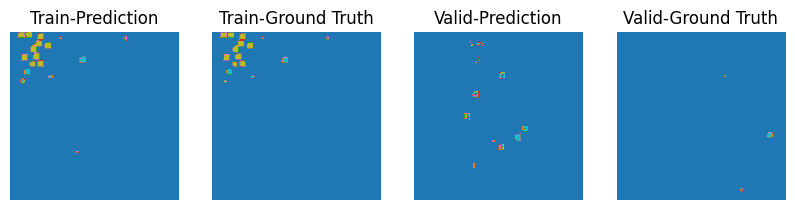

Epoch: 60, Loss: 9.215938234774512e-07


Valid-Epoch: 61, Loss: 4.424236743999205: 100%|██████████| 92/92 [00:03<00:00, 30.31it/s] 


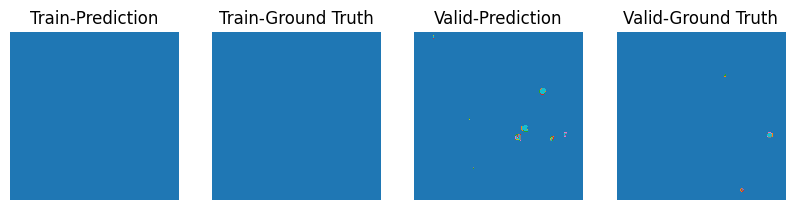

Epoch: 61, Loss: 3.317451410111971e-05


Valid-Epoch: 62, Loss: 4.662331154418138: 100%|██████████| 92/92 [00:02<00:00, 31.03it/s] 


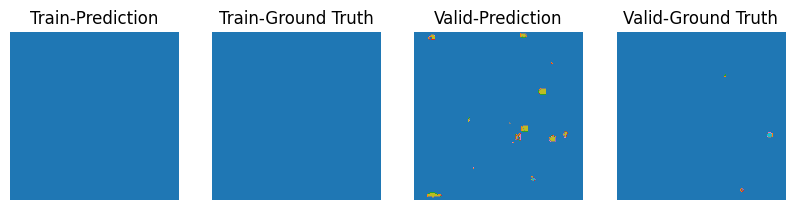

Epoch: 62, Loss: 0.006298250053077936


Valid-Epoch: 63, Loss: 3.375240688805681: 100%|██████████| 92/92 [00:02<00:00, 31.14it/s] 


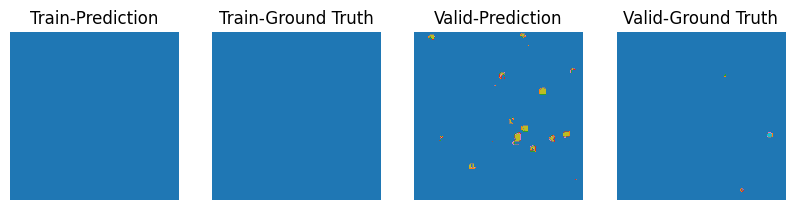

Epoch: 63, Loss: 0.00020807473629247397


Valid-Epoch: 64, Loss: 3.8590066995579106: 100%|██████████| 92/92 [00:02<00:00, 31.19it/s]


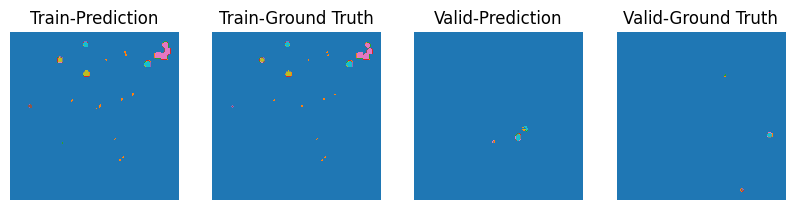

Epoch: 64, Loss: 5.0919911700475495e-06


Valid-Epoch: 65, Loss: 4.298272352580249: 100%|██████████| 92/92 [00:02<00:00, 31.22it/s] 


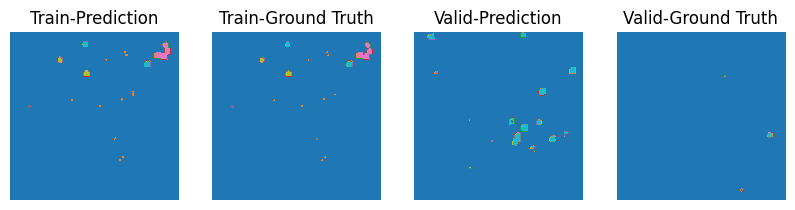

Epoch: 65, Loss: 0.0004668051260523498


Valid-Epoch: 66, Loss: 3.9536171025401012: 100%|██████████| 92/92 [00:03<00:00, 30.07it/s]


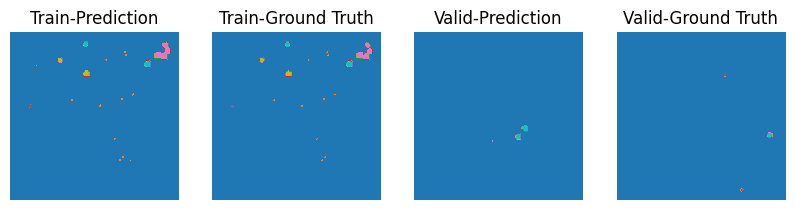

Epoch: 66, Loss: 5.588964540947927e-06


Valid-Epoch: 67, Loss: 3.553636497747628: 100%|██████████| 92/92 [00:03<00:00, 29.65it/s] 


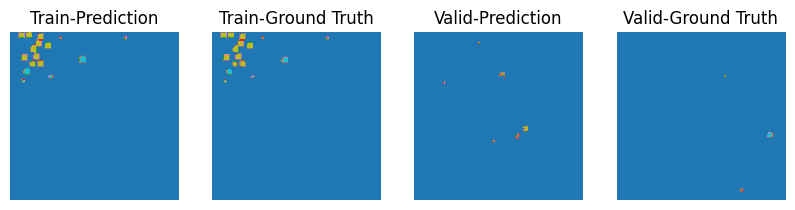

Epoch: 67, Loss: 6.46604603389278e-05


Valid-Epoch: 68, Loss: 3.7384493482050214: 100%|██████████| 92/92 [00:03<00:00, 30.05it/s]


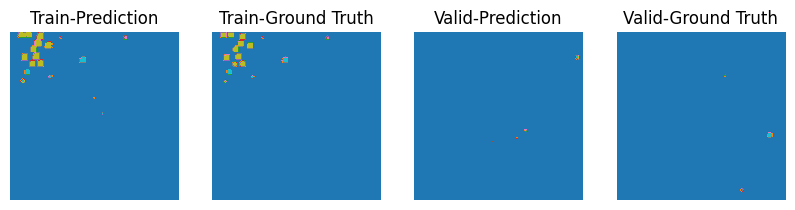

Epoch: 68, Loss: 2.9283655749168247e-05


Valid-Epoch: 69, Loss: 3.358980429173319: 100%|██████████| 92/92 [00:02<00:00, 30.82it/s] 


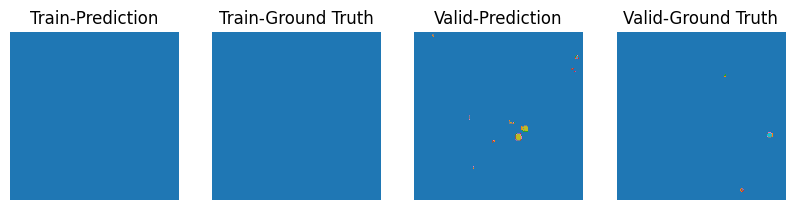

Epoch: 69, Loss: 1.2821132258977741e-05


Valid-Epoch: 70, Loss: 3.5117845925011233: 100%|██████████| 92/92 [00:02<00:00, 31.50it/s]


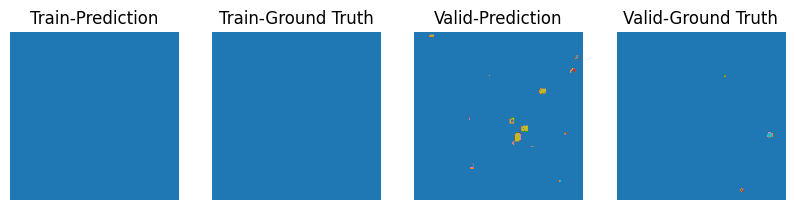

Epoch: 70, Loss: 0.00024081632727757096


Valid-Epoch: 71, Loss: 3.991372039586256: 100%|██████████| 92/92 [00:03<00:00, 29.79it/s] 


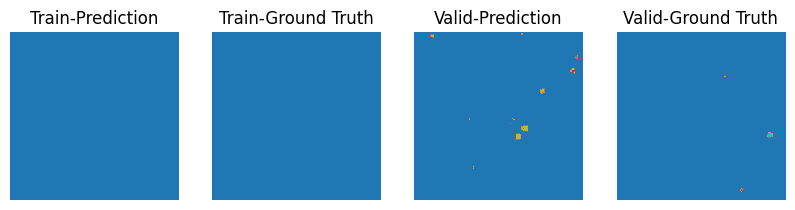

Epoch: 71, Loss: 2.1851879864698276e-05


Valid-Epoch: 72, Loss: 4.080039166624766: 100%|██████████| 92/92 [00:03<00:00, 29.57it/s] 


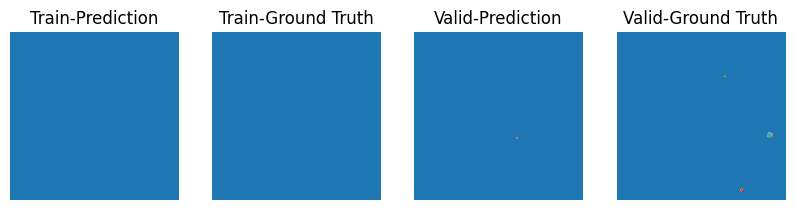

Epoch: 72, Loss: 0.00059118727222085


Valid-Epoch: 73, Loss: 3.785617967010432: 100%|██████████| 92/92 [00:03<00:00, 29.69it/s] 


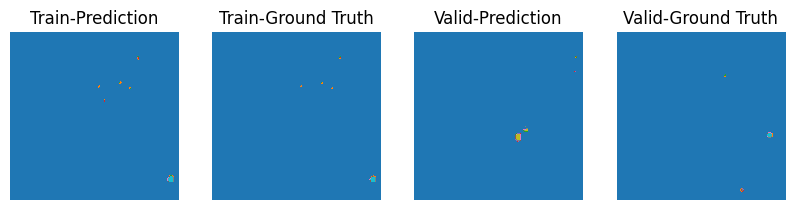

Epoch: 73, Loss: 0.0007780537125654519


Valid-Epoch: 74, Loss: 3.7314401512151627: 100%|██████████| 92/92 [00:03<00:00, 30.22it/s]


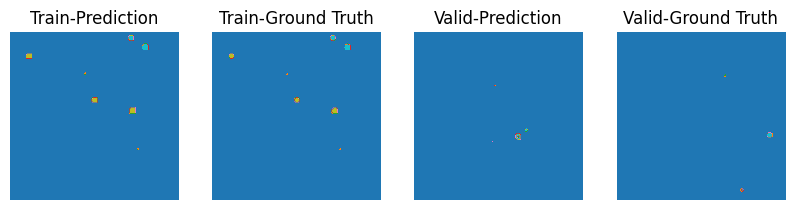

Epoch: 74, Loss: 1.175376382889226e-05


Valid-Epoch: 75, Loss: 4.488748360906846: 100%|██████████| 92/92 [00:03<00:00, 28.77it/s] 


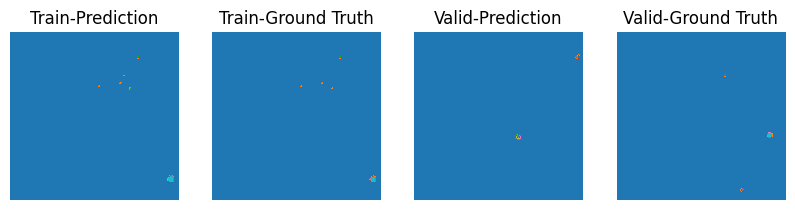

Epoch: 75, Loss: 0.0003657035413198173


Valid-Epoch: 76, Loss: 3.5751190238138206: 100%|██████████| 92/92 [00:03<00:00, 30.09it/s]


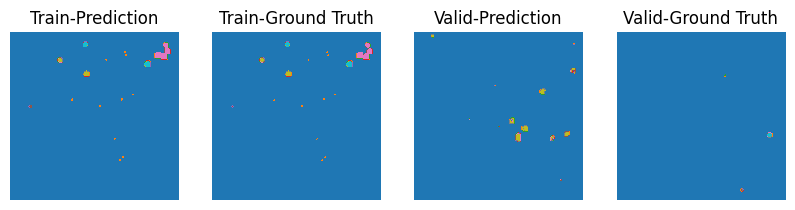

Epoch: 76, Loss: 0.0007111187442205846


Valid-Epoch: 77, Loss: 3.9358504826618925: 100%|██████████| 92/92 [00:02<00:00, 30.88it/s]


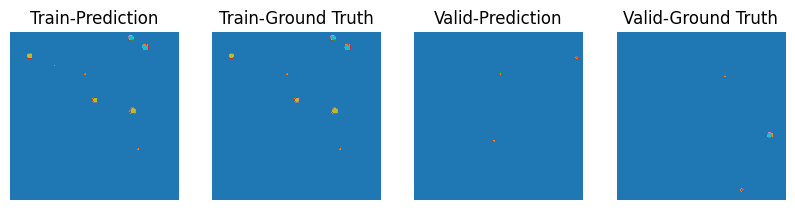

Epoch: 77, Loss: 0.0017934271600097418


Valid-Epoch: 78, Loss: 4.490410007811185: 100%|██████████| 92/92 [00:03<00:00, 29.73it/s] 


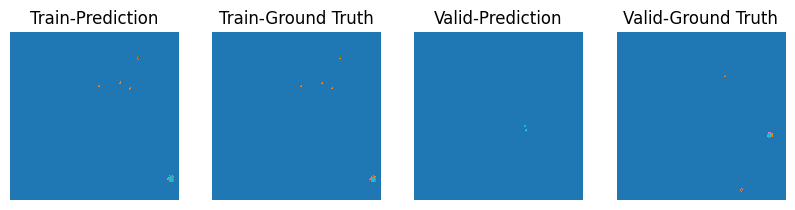

Epoch: 78, Loss: 2.772904110770469e-07


Valid-Epoch: 79, Loss: 4.294835692087607: 100%|██████████| 92/92 [00:02<00:00, 30.74it/s] 


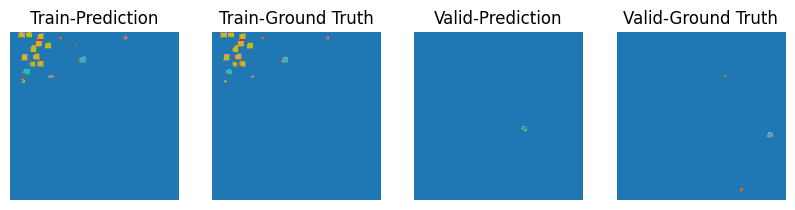

Epoch: 79, Loss: 5.407543540059123e-06


Valid-Epoch: 80, Loss: 3.159153651224662: 100%|██████████| 92/92 [00:02<00:00, 31.38it/s] 


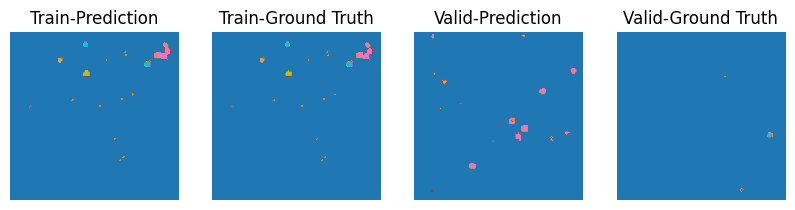

Epoch: 80, Loss: 0.001016772584989667


Valid-Epoch: 81, Loss: 3.691473790522818: 100%|██████████| 92/92 [00:02<00:00, 30.88it/s] 


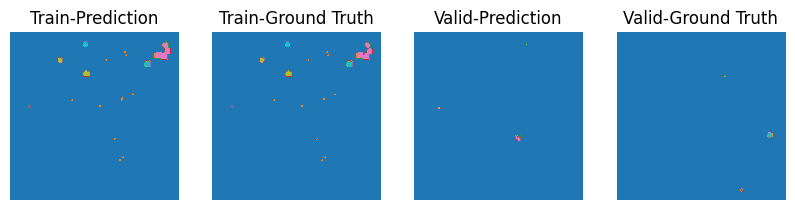

Epoch: 81, Loss: 7.567191460111644e-06


Valid-Epoch: 82, Loss: 5.251134177231111: 100%|██████████| 92/92 [00:02<00:00, 30.67it/s] 


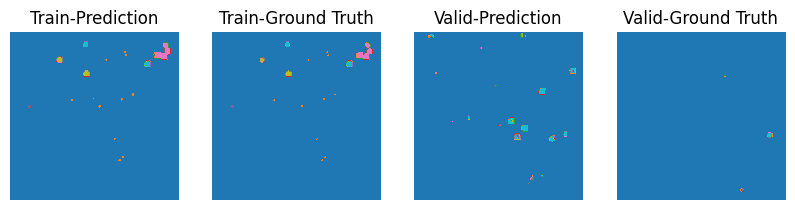

Epoch: 82, Loss: 0.0005997814587317407


Valid-Epoch: 83, Loss: 4.301791422845855: 100%|██████████| 92/92 [00:03<00:00, 28.86it/s]    


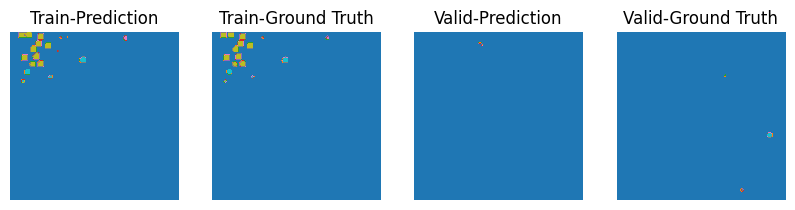

Epoch: 83, Loss: 4.446232253485505e-07


Valid-Epoch: 84, Loss: 4.108027024356928: 100%|██████████| 92/92 [00:03<00:00, 29.99it/s] 


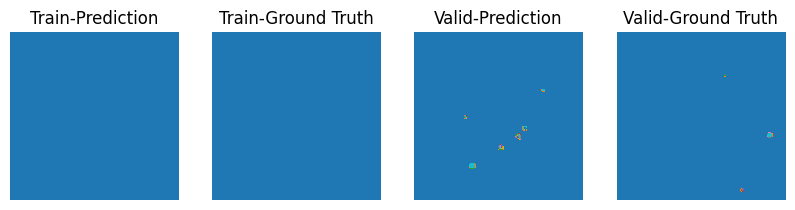

Epoch: 84, Loss: 1.065359242602426e-06


Valid-Epoch: 85, Loss: 3.381484073460975: 100%|██████████| 92/92 [00:02<00:00, 31.31it/s] 


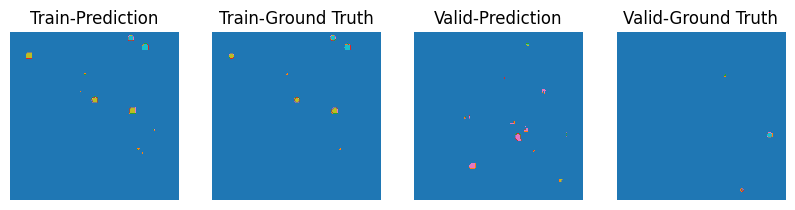

Epoch: 85, Loss: 7.958360220072791e-05


Valid-Epoch: 86, Loss: 3.9966485177960207: 100%|██████████| 92/92 [00:03<00:00, 30.55it/s]


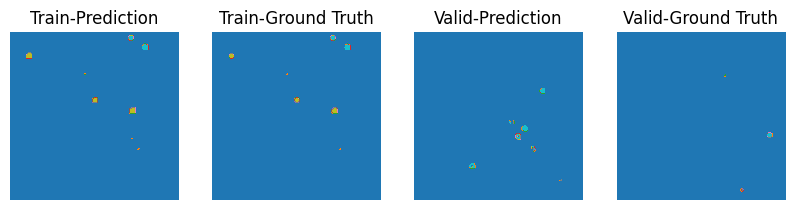

Epoch: 86, Loss: 2.230683321613469e-06


Valid-Epoch: 87, Loss: 4.551286640857313: 100%|██████████| 92/92 [00:02<00:00, 30.84it/s] 


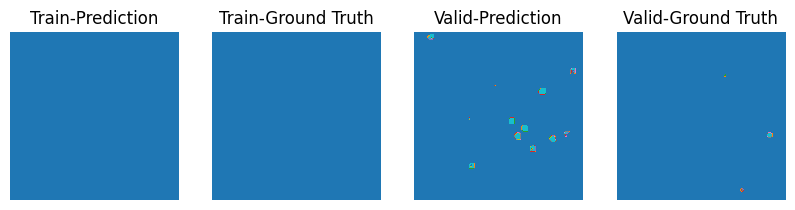

Epoch: 87, Loss: 1.5903885923762573e-06


Valid-Epoch: 88, Loss: 3.122339155261453: 100%|██████████| 92/92 [00:03<00:00, 29.86it/s] 


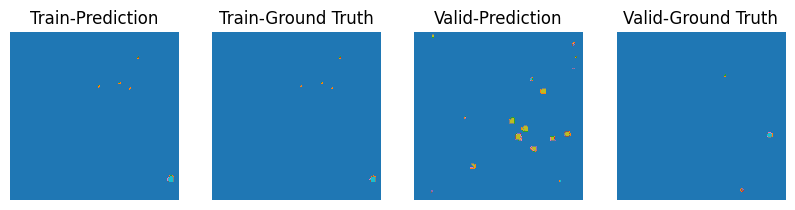

Epoch: 88, Loss: 0.002175805624574423


Valid-Epoch: 89, Loss: 3.7997138124699177: 100%|██████████| 92/92 [00:02<00:00, 31.45it/s]


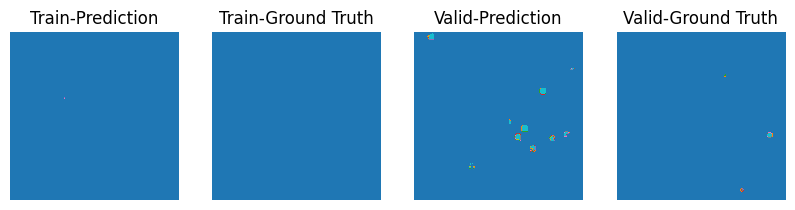

Epoch: 89, Loss: 0.00012812191562261432


Valid-Epoch: 90, Loss: 4.0586326987452965: 100%|██████████| 92/92 [00:03<00:00, 30.26it/s]


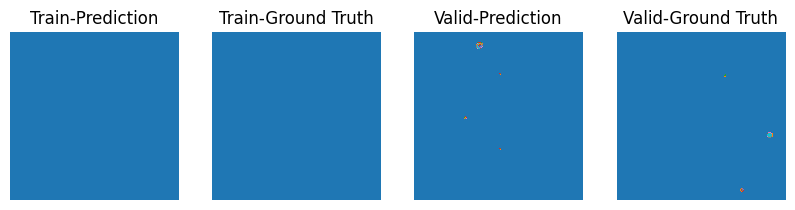

Epoch: 90, Loss: 1.426008680027735e-07


Valid-Epoch: 91, Loss: 4.386554493763628: 100%|██████████| 92/92 [00:03<00:00, 29.86it/s] 


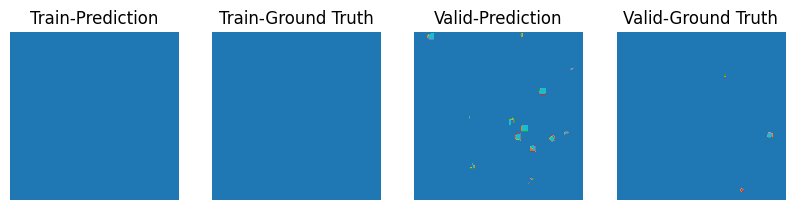

Epoch: 91, Loss: 6.358313839882612e-06


Valid-Epoch: 92, Loss: 4.34476278656836: 100%|██████████| 92/92 [00:03<00:00, 30.54it/s]  


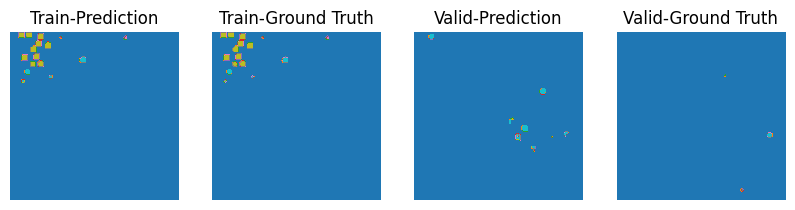

Epoch: 92, Loss: 5.015976967115421e-07


Valid-Epoch: 93, Loss: 4.104049979014897: 100%|██████████| 92/92 [00:03<00:00, 26.03it/s] 


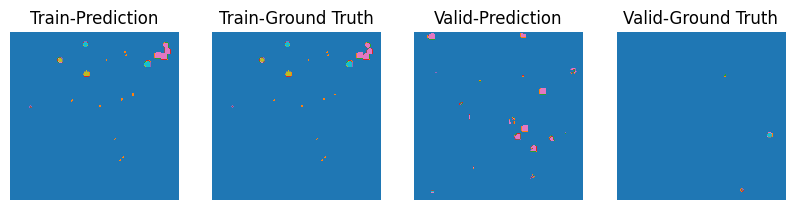

Epoch: 93, Loss: 9.780184882401954e-06


Valid-Epoch: 94, Loss: 3.53705151256556: 100%|██████████| 92/92 [00:03<00:00, 29.55it/s]  


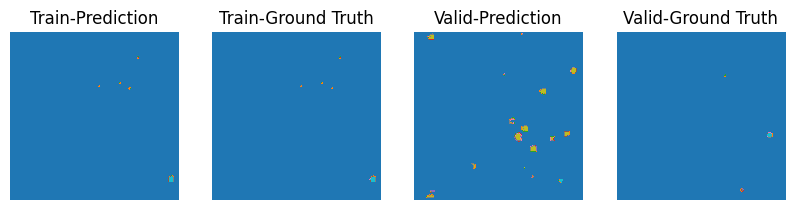

Epoch: 94, Loss: 0.0012608570978045464


Valid-Epoch: 95, Loss: 4.926101329688102: 100%|██████████| 92/92 [00:03<00:00, 29.93it/s] 


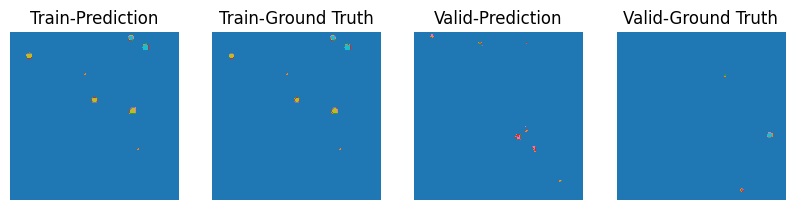

Epoch: 95, Loss: 0.00036218552850186825


Valid-Epoch: 96, Loss: 5.044295491131583: 100%|██████████| 92/92 [00:02<00:00, 30.72it/s] 


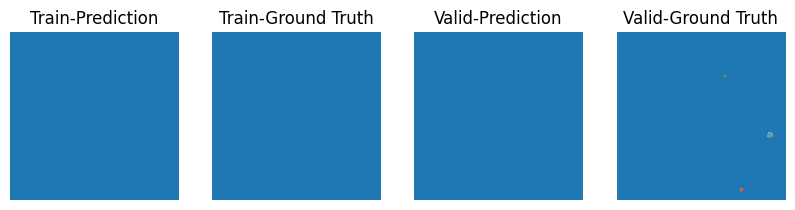

Epoch: 96, Loss: 0.0002536555693950504


Valid-Epoch: 97, Loss: 4.7816667176868775: 100%|██████████| 92/92 [00:02<00:00, 30.87it/s]


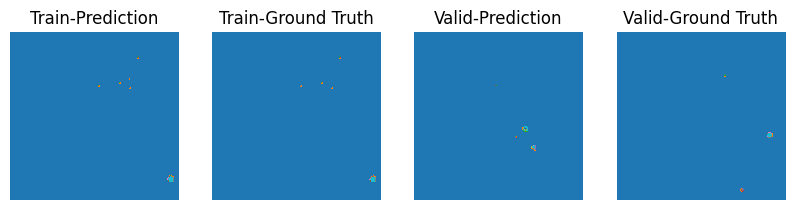

Epoch: 97, Loss: 3.4168024285463616e-05


Valid-Epoch: 98, Loss: 5.007968976250292: 100%|██████████| 92/92 [00:02<00:00, 31.07it/s] 


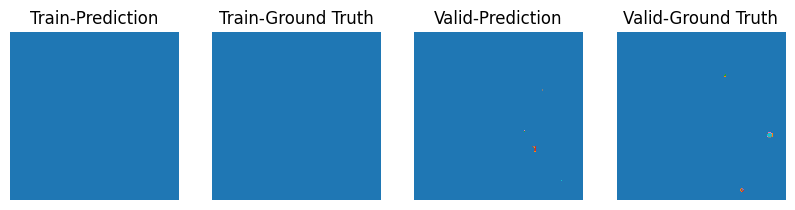

Epoch: 98, Loss: 5.942758798482828e-05


Valid-Epoch: 99, Loss: 4.518524290748044: 100%|██████████| 92/92 [00:03<00:00, 29.25it/s] 


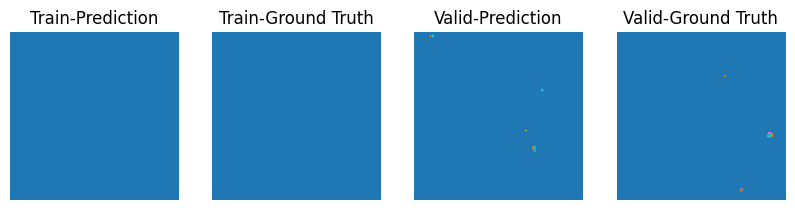

Epoch: 99, Loss: 1.923632407851983e-05


In [6]:
model = UNet_2D().to("cuda")
model.eval()


def save_images(
    train_pred_tomogram,
    train_gt_tomogram,
    valid_pred_tomogram,
    valid_gt_tomogram,
    save_dir="images",
    epoch=0,
):
    import os

    train_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "train")
    valid_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "valid")
    os.makedirs(train_save_dir, exist_ok=True)
    os.makedirs(valid_save_dir, exist_ok=True)
    # 可視化
    for i in range(len(train_pred_tomogram)):
        train_pred = train_pred_tomogram[i].argmax(1).squeeze(0)
        train_gt = train_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(train_pred, cmap="tab10")
        ax.set_title("Train-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(train_gt, cmap="tab10")
        ax.set_title("Train-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(train_save_dir, f"train_{i}.png"))
        plt.close()

    for i in range(len(valid_pred_tomogram)):
        valid_pred = valid_pred_tomogram[i].argmax(1).squeeze(0)
        valid_gt = valid_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(valid_pred, cmap="tab10")
        ax.set_title("Valid-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(valid_gt, cmap="tab10")
        ax.set_title("Valid-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(valid_save_dir, f"valid_{i}.png"))
        plt.close()


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_loss = np.inf

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = []
    train_gt_tomogram = []
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0]))
    for data in train_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            optimizer.zero_grad()
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]
            output = model(input_)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            train_pred_tomogram.append(output.cpu().detach().numpy())
            train_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    valid_pred_tomogram = []
    valid_gt_tomogram = []
    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram.append(output.cpu().detach().numpy())
            valid_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    if np.mean(valid_loss) < best_loss:
        best_loss = np.mean(valid_loss)
        best_model = model
        torch.save(best_model.state_dict(), "best_model.pth")

    # 可視化
    index = 50

    # 2つの画像を並べて表示
    plt.figure(figsize=(10, 5))

    # 2つの画像を並べて表示
    ax = plt.subplot(1, 4, 1)
    ax.imshow(train_pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
    ax.set_title("Train-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(train_gt_tomogram[index].squeeze(0), cmap="tab10")
    ax.set_title("Train-Ground Truth")
    ax.axis("off")

    ax = plt.subplot(1, 4, 3)
    ax.imshow(valid_pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 4)
    ax.imshow(valid_gt_tomogram[index].squeeze(0), cmap="tab10")
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    plt.show()

    # save_images(
    #     train_gt_tomogram=train_gt_tomogram,
    #     train_pred_tomogram=train_pred_tomogram,
    #     valid_gt_tomogram=valid_gt_tomogram,
    #     valid_pred_tomogram=valid_pred_tomogram,
    #     save_dir="images",
    #     epoch=epoch,
    # )

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [7]:
normalized_tomogram.shape, segmentation_map.shape

((46, 160, 160), torch.Size([1, 46, 160, 160]))

In [8]:
model = UNet_2D().to("cuda")
model.load_state_dict(torch.load("best_model.pth"))
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([1e-4, 1, 0, 2, 1, 2, 1]).to("cuda")
)

pred_tomogram = []
gt_tomogram = []

valid_loss = []

model.eval()
tq = tqdm(valid_loader)
for data in valid_loader:
    tomogram = data["normalized_tomogram"].to("cuda")
    segmentation_map = data["segmentation_map"].to("cuda").long()

    for i in range(tomogram.shape[1]):
        input_ = tomogram[:, i].unsqueeze(0)
        gt = segmentation_map[:, i]

        output = model(input_)
        loss = criterion(output, gt)

        valid_loss.append(loss.item())
        tq.set_description(f"Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
        tq.update(1)

        pred_tomogram.append(output.cpu().detach().numpy())
        gt_tomogram.append(gt.cpu().detach().numpy())
tq.close()

Epoch: 99, Loss: 0.3608398022858993: : 92it [00:03, 29.75it/s]                     


In [9]:
len(pred_tomogram), len(gt_tomogram)

(92, 92)

In [10]:
pred_tomogram[0].argmax(1).shape

(1, 160, 160)

In [11]:
pred_tomogram[0].argmax(1)

array([[[0, 0, 0, ..., 0, 0, 5],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

IndexError: list index out of range

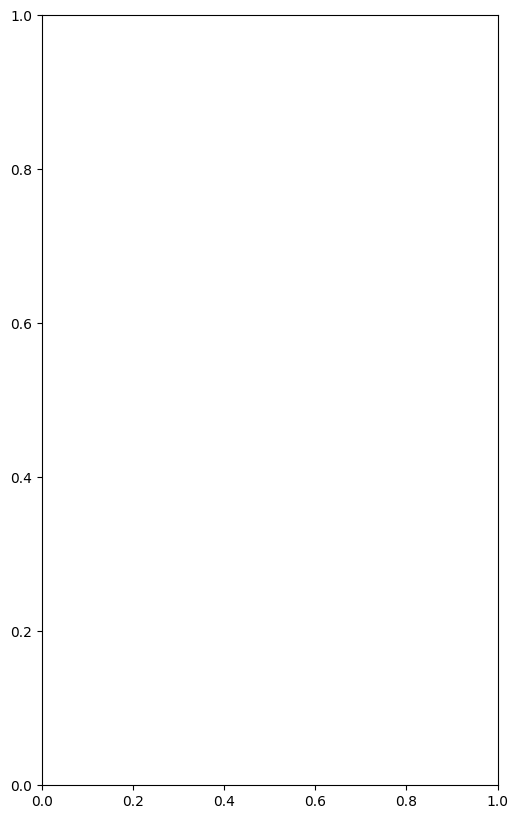

In [12]:
# 可視化
index = 120

# 2つの画像を並べて表示
# plt.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
plt.figure(figsize=(20, 10))

# 2つの画像を並べて表示
ax = plt.subplot(1, 3, 1)
ax.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
ax.set_title("Prediction")
ax.axis("off")

ax = plt.subplot(1, 3, 2)
ax.imshow(gt_tomogram[index].squeeze(0), cmap="tab10")
ax.set_title("Ground Truth")
ax.axis("off")

ax = plt.subplot(1, 3, 3)
ax.imshow(normalized_tomogram[index], cmap="gray")
ax.set_title("Ground Truth")
ax.axis("off")

In [ ]:
normalized_tomogram[index]

In [ ]:
gt_tomogram[index].squeeze(0).shape

In [ ]:
pred_tomogram[index].argmax(1).shape